In [1]:
# import os
# import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

# os.environ["KERAS_BACKEND"] = "torch"
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import LearningRateScheduler
from keras import backend as K
from keras.metrics import MeanSquaredError

# os.environ["KERAS_BACKEND"] = "torch"
print("Keras backend:", K.backend())
# print(torch.version.cuda)

# print(torch.cuda.is_available())  # Should return True
# print(torch.cuda.current_device())  # Device ID
# print(torch.cuda.get_device_name(0))

Keras backend: tensorflow


In [29]:
# Generate or load time series data
# np.random.seed(0)
# data = np.sin(np.linspace(0, 100, 20000)) + 0.1 * np.random.normal(size=20000)

# train_df = pd.read_csv("train.csv", parse_dates=["Datetime"], dayfirst=True)
# data = train_df["Count"].values

train_df = pd.read_csv("NVidia_stock_history.csv", parse_dates=["Date"], dayfirst=True)
data = train_df["Volume"].values


C:\Users\maria\AppData\Local\Temp\ipykernel_14236\2823174283.py:8: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S%z format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  train_df = pd.read_csv("NVidia_stock_history.csv", parse_dates=["Date"], dayfirst=True)


In [30]:
def create_data(data, sequence_length, p): 
    data = data.reshape(-1, 1)

    split = int(p * len(data))
    train_data, test_data = data[:split], data[split - sequence_length:]

    std_scaler = StandardScaler()
    train_data = std_scaler.fit_transform(train_data)
    test_data = std_scaler.transform(test_data)
    
    X_train, y_train = [], []
    for i in range(len(train_data) - sequence_length):
        X_train.append(train_data[i : i + sequence_length])
        y_train.append(train_data[i + sequence_length])
    X_train, y_train = np.array(X_train), np.array(y_train)

    X_test, y_test = [], []
    for i in range(len(test_data) - sequence_length):
        X_test.append(test_data[i : i + sequence_length])
        y_test.append(test_data[i + sequence_length])
    X_test, y_test = np.array(X_test), np.array(y_test)
  
    return X_train, y_train, X_test, y_test, std_scaler


p = 0.95
sequence_length = 30
X_train, y_train, X_test, y_test, std_scaler = create_data(data, sequence_length, p)


In [31]:
def build_model():
    model = Sequential()
    model.add(LSTM(64, activation='tanh', input_shape=(sequence_length, 1), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(32, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))
    
    # model.add(Dense(32, activation='relu'))
    # model.add(BatchNormalization())
    
    model.add(Dense(1))
    
    model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

    return model


model = build_model()

C:\Users\maria\anaconda3\envs\cuda\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
# Train the model
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * np.exp(-0.1)


learningRateScheduler = LearningRateScheduler(scheduler, verbose=0)
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), callbacks=[learningRateScheduler])


Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5975 - mean_squared_error: 0.5975 - val_loss: 0.1200 - val_mean_squared_error: 0.1263 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.5407 - mean_squared_error: 0.5407 - val_loss: 0.1000 - val_mean_squared_error: 0.1078 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5759 - mean_squared_error: 0.5759 - val_loss: 0.0957 - val_mean_squared_error: 0.1012 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.5065 - mean_squared_error: 0.5065 - val_loss: 0.0962 - val_mean_squared_error: 0.1024 - learning_rate: 0.0010
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.4740 - mean_squared_error: 0.4741 - val_loss: 0.0947 - val_mean_squared_error: 0.1017 - learning_rate: 0.0010
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.6254 - mean_squared_error: 0.6254 - val_loss: 0.0920 - val_mean_squared_

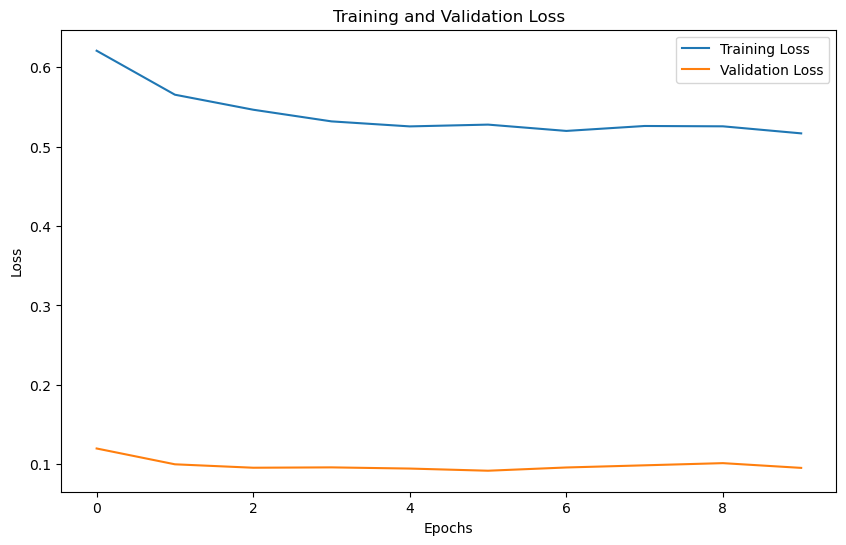

In [33]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [34]:
# get predictions on train and test
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


19.58011410341316

In [26]:
# inverse transform data
# y_test = scaler.inverse_transform(y_test)
# train_predictions = scaler.inverse_transform(train_predictions)
# test_predictions = scaler.inverse_transform(test_predictions)

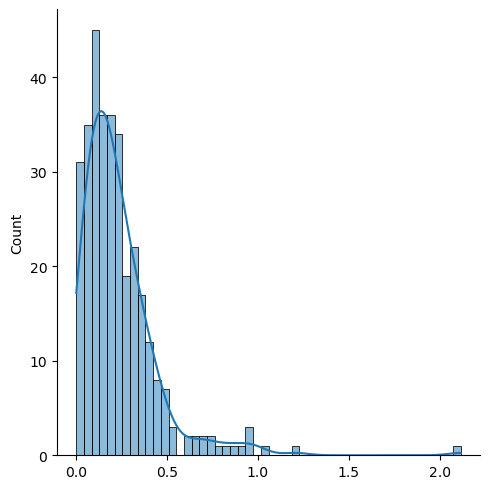

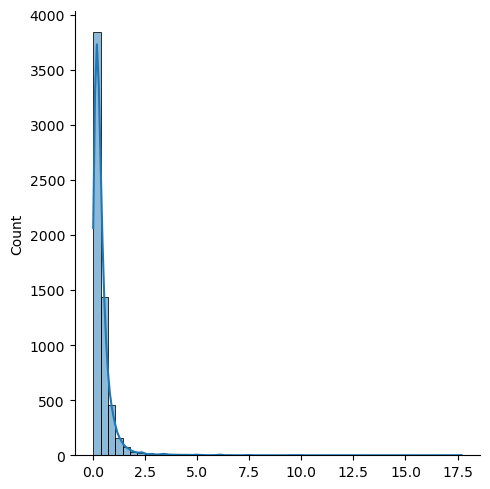

In [35]:

test_mae_loss = np.mean(np.abs(test_predictions - y_test), axis=1)
sns.displot(test_mae_loss, bins=50, kde=True)

train_mae_loss = np.mean(np.abs(train_predictions - y_train), axis=1)
sns.displot(train_mae_loss, bins=50, kde=True)

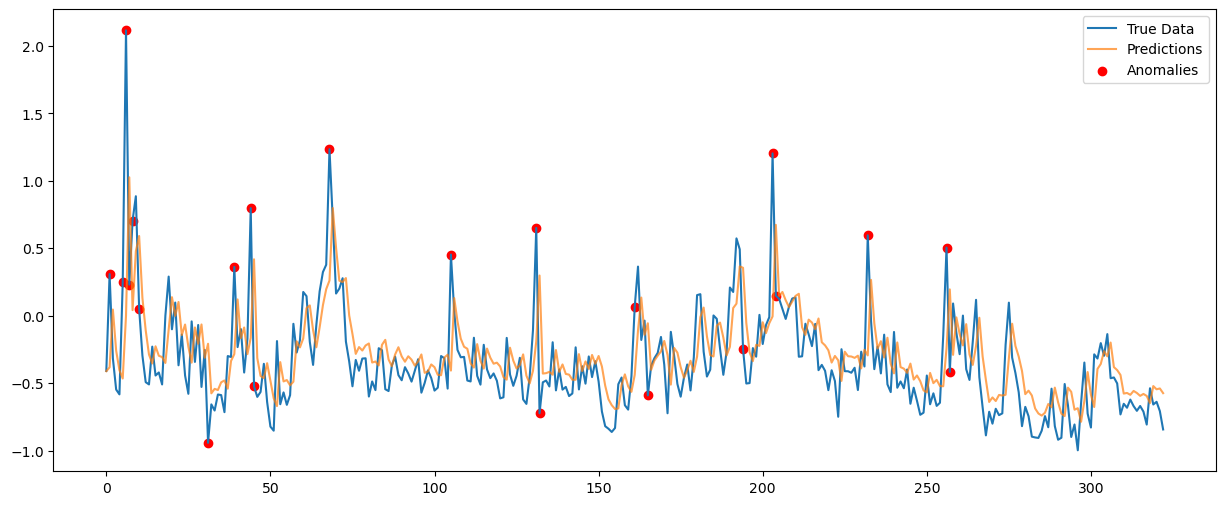

In [36]:
# Calculate loss
loss = np.mean(np.abs(test_predictions - y_test), axis=1)

threshold = 0.5
anomalies = loss > threshold

# Visualize the results
plt.figure(figsize=(15, 6))
plt.plot(range(len(y_test)), y_test, label='True Data')
plt.plot(range(len(test_predictions)), test_predictions, label='Predictions', alpha=0.7)
plt.scatter(np.where(anomalies)[0], y_test[anomalies], color='red', label='Anomalies')
plt.legend()
plt.show()